# Simulating multivariate effects with intersubject variability

In the previous examples, we set the size of the effect to 0.5. The effect size modulates the decoding accuracy, by taking into account the noise present at teh single subject level. Importantly, the amplitude of the effect was assumed to be fixed across participants. However, in most data sets, that will not be the case, as the **true** decoding accuracy surely varies between participants.

In order to simulate between participants variability, you can specify a between subjects noise parameter. Specifically, instead of simulating multivariate effect of the same strength across participants, we draw the effect strength from a normal distribution with a given mean and standard deviation. 

## 1. Setting up the simulation

We will stick to the same parameters as before, with the kernel and everything, just adding the noise parameter.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma as gamma_dist
import matplotlib.pyplot as plt

# Creating the design matrix of our 2 by two balanced design:
X = np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T

# Add descriptors:
cond_names = ["category", "attention"]
X = pd.DataFrame(
    X, columns=cond_names
)  # Add a column for the interaction between category and attention
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"},
}

# Specifying the effects:
effects = [
    {"condition": "category", "windows": [0.1, 0.2], "effect_size": 0.5},
    {"condition": "attention", "windows": [0.3, 0.4], "effect_size": 0.5},
]  # Packaging them in a list to pass to the simulator class

# Data parameters:
n_channels = 32  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 2  # Variance of the data
ch_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz
tmin = -0.25
tmax = 1.0

# Generate our kernel:
t = np.arange(0, 1, 1 / sfreq)  # time vector (in seconds)
kernel = gamma_dist(a=2, scale=0.08).pdf(t)
kernel /= kernel.max() * 5  # Normalize peak to 0.25

# Between subject noise:
intersub_noise_std = 1 / 8

## 2. Simulating the data

The simulation of the data is exactly the same as before, except with the addition of intersubjects noise:

In [2]:
from multisim import Simulator

sims = Simulator(
    X,  # Design matrix
    effects,  # Effects to simulate
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

## 3. Decoding analysis and plotting

We will perform the analysis on all subjects and show how the added between subject noise changes the results

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore
from mne.stats import permutation_cluster_1samp_test, bootstrap_confidence_interval

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])
att_lbl = np.array([mapping["attention"][val] for val in X.to_numpy()[:, 1]])

scores_category = []
scores_attention = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
    # Classification of attention:
    scores_attention.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, att_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)
scores_attention = np.array(scores_attention)

# Group level statistics:
# Cluster based permutation test for the category:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_category - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_cate = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_cate[clusters[c]] = True

# Cluster based permutation test for the attention:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_attention - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_att = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_att[clusters[c]] = True

Using a threshold of 1.729133
stat_fun(H1): min=-2.7821216769418657 max=4.770225544943381
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 1.729133
stat_fun(H1): min=-2.5624485156151886 max=5.705472544138154
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

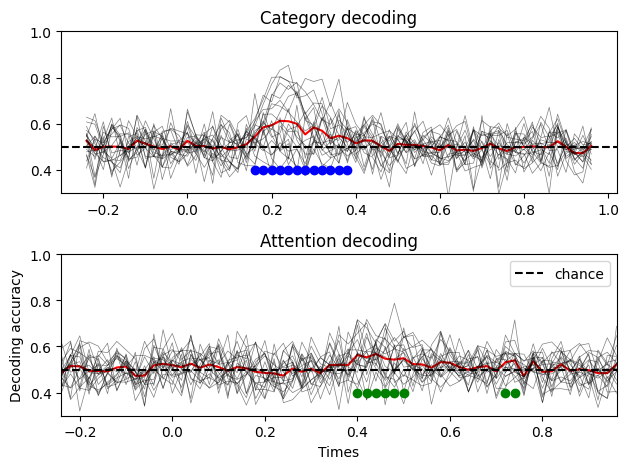

In [4]:
# Plot the results
fig, ax = plt.subplots(2, 1)

# Plot the results of category decoding:
ax[0].plot(epochs[0].times, np.mean(scores_category, axis=0), color="r")
ax[0].plot(epochs[0].times, scores_category.T, color="k", alpha=0.5, linewidth=0.5)

ax[0].plot(
    epochs[0].times[sig_mask_cate],
    np.ones(np.sum(sig_mask_cate)) * 0.4,
    marker="o",
    linestyle="None",
    color="b",
)
ax[0].set_title("Category decoding")
ax[0].axhline(0.5, color="k", linestyle="--", label="chance")
ax[0].set_ylim([0.3, 1.0])
# Plot the results of attention condition:
ax[1].plot(epochs[0].times, np.mean(scores_attention, axis=0), color="r")
ax[1].plot(epochs[0].times, scores_attention.T, color="k", alpha=0.5, linewidth=0.5)
ax[1].plot(
    epochs[0].times[sig_mask_att],
    np.ones(np.sum(sig_mask_att)) * 0.4,
    marker="o",
    linestyle="None",
    color="g",
)
ax[1].set_title("Attention decoding")
ax[1].axhline(0.5, color="k", linestyle="--", label="chance")
ax[1].set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax[1].set_xlabel("Times")
ax[1].set_ylabel("Decoding accuracy")
ax[1].set_ylim([0.3, 1.0])
ax[1].legend()
plt.tight_layout()
plt.show()

The results seem similar to what we had before, though the variance of each subjects decoding is quite high. By comparison, here is what the results look like if we fix the intersubject variance: 

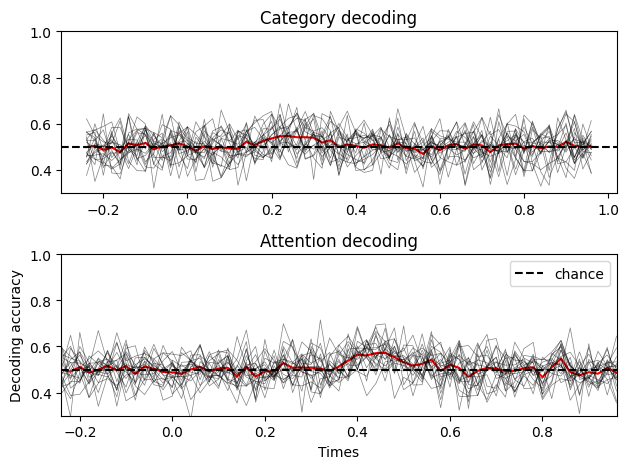

In [5]:
sims = Simulator(
    X,  # Design matrix
    effects,  # Effects to simulate
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=0,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

# Apply decoding:
scores_category = []
scores_attention = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
    # Classification of attention:
    scores_attention.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, att_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)
scores_attention = np.array(scores_attention)

# Plot the results:
fig, ax = plt.subplots(2, 1)

# Plot the results of category decoding:
ax[0].plot(epochs[0].times, np.mean(scores_category, axis=0), color="r")
ax[0].plot(epochs[0].times, scores_category.T, color="k", alpha=0.5, linewidth=0.5)
ax[0].set_title("Category decoding")
ax[0].axhline(0.5, color="k", linestyle="--", label="chance")
ax[0].set_ylim([0.3, 1.0])
# Plot the results of attention condition:
ax[1].plot(epochs[0].times, np.mean(scores_attention, axis=0), color="r")
ax[1].plot(epochs[0].times, scores_attention.T, color="k", alpha=0.5, linewidth=0.5)
ax[1].set_title("Attention decoding")
ax[1].axhline(0.5, color="k", linestyle="--", label="chance")
ax[1].set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax[1].set_xlabel("Times")
ax[1].set_ylabel("Decoding accuracy")
ax[1].set_ylim([0.3, 1.0])
ax[1].legend()
plt.tight_layout()
plt.show()

As you can see, when no between subject variance is specified, the decoding accuracy is more concentrated around the mean, which makes sense. Adding a between subject variance term make the data more realistic, as you will typically have subjects for which the decoding accuracy is really high, and others not so much.

In the next tutorial, we will explore how to specify various temporal generalization patterns of the simulated data.